In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os

Mounted at /content/drive


In [ ]:
'''
Installing packages for rendering the game on Colab
'''

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1
!pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 91.2 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.3.0
    Uninstalling pygame-2.3.0:
      Successfully uninstalled pygame-2.3.0


In [ ]:
'''
A bunch of necessary imports
'''
import numpy as np
import seaborn as sbn
import torch
import torch.nn as nn  
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
import tensorflow_docs.vis.embed as embed
from IPython import display as ipythondisplay
from PIL import Image
import uuid
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Q-Network Code

In [ ]:
'''
Bunch of Hyper parameters (Which you might have to tune later **wink wink**)
'''

BUFFER_SIZE = int(1e5)  # replay buffer size 
BATCH_SIZE = 64         # minibatch size 
GAMMA = 0.99            # discount factor
LR = 5e-4               # learning rate 
UPDATE_EVERY = 20       # how often to update the network (When Q target is present) 
NUM_HLAYERS = 2
HLAYER_SIZES = [128, 64]
TRUNC_LIM = 1

class QNetwork(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcls = nn.ModuleList()
        for i in range(NUM_HLAYERS+1):
            if (i == 0):
                fc = nn.Linear(state_size, HLAYER_SIZES[0])
            elif (i == NUM_HLAYERS):
                fc = nn.Linear(HLAYER_SIZES[i-1], action_size)
            else:
                fc = nn.Linear(HLAYER_SIZES[i-1], HLAYER_SIZES[i])
            self.fcls.append(fc)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        for i in range(len(self.fcls)-1):
            fc = self.fcls[i]
            if i == 0:
                x = F.relu(fc(state))
            else:
                x = F.relu(fc(x))
        fc = self.fcls[len(self.fcls) - 1]
        return fc(x)

### Replay Buffer:

This is a 'deque' that helps us store experiences. Recall why we use such a technique.

In [ ]:
from collections import deque, namedtuple

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.rsg = np.random.RandomState(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        idxs = self.rsg.choice(len(self.memory), size=self.batch_size, replace=False)
        mem = self.memory
        states = torch.from_numpy(np.vstack([mem[i].state for i in idxs if mem[i] is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([mem[i].action for i in idxs if mem[i] is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([mem[i].reward for i in idxs if mem[i] is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([mem[i].next_state for i in idxs if mem[i] is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([mem[i].done for i in idxs if mem[i] is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### DQN Agent Code:

Truncation is done optionally with the hope that it improves stability.

In [ ]:
from scipy.special import softmax
class dqn_agent():
    def __init__(self, state_size, action_size, seed, atype='epsilon-greedy'):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.rsg = np.random.RandomState(seed)

        ''' Q-Network '''
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
        self.t_step = 0

        if atype == 'epsilon-greedy':
            self.act = self.eps_act 
        else:
            self.act = self.soft_act
    
    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)
        
        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''      
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def eps_act(self, state, eps=0.):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        
        ''' Epsilon-greedy action selection (Already Present) '''
        if self.rsg.random() < eps:
            return self.rsg.choice(np.arange(self.action_size))
        else:
            return np.argmax(action_values.cpu().data.numpy())

    def soft_act(self, state, beta=1.0):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Softmax action selection (Implemented) '''
        a_values = torch.squeeze(action_values).cpu().squeeze().data.numpy()
        return self.rsg.choice(np.arange(self.action_size), size=1, p=softmax(a_values/beta))[0]

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences

        ''' Get max predicted Q values (for next states) from target model'''
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        ''' Get expected Q values from local model '''
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()
        
        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-TRUNC_LIM, +TRUNC_LIM)
            
        self.optimizer.step()

### DQN algorithm

In [ ]:
def reward_shaping(state, next_state): 
    return -100*(np.abs(next_state[2])- np.abs(state[2]))

In [ ]:
''' Defining DQN Algorithm with epsilon annealing'''

def dqn(env, agent, env_score_req, use_eps = True, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.05, decay_factor=0.995, beta_start=1.5, beta_end=0.5):

    scores = []
    num_steps = []                 
    ''' list containing scores from each episode '''
    
    scores_window= deque(maxlen=100)  
    ''' last 100 scores for checking if the avg is more than -110 '''

    eps = eps_start
    beta = beta_start
        
    ''' initialize epsilon '''
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            if use_eps:
                action = agent.act(state, eps)
            else:
                action = agent.act(state, beta)
            next_state, reward, done, _ = env.step(action)
            shaped_reward = reward_shaping(state, next_state)
            agent.step(state, action, shaped_reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        num_steps.append(t)
        scores.append(score)
        scores_window.append(score) 
        ''' save most recent score '''           

        eps = max(eps_end, eps * decay_factor) 
        beta = max(beta_end, beta * decay_factor) 
        ''' decrease epsilon, beta '''

        print('\rEpisode {}\tAverage Score: {:.2f}\teps {}'.format(i_episode, np.mean(scores_window),eps) ,end="")     
        if i_episode % 100 == 0: 
           print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=env_score_req:
           print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
           break
    return [np.array(scores), np.array(num_steps), i_episode]

### Plotting and Rendering

In [ ]:
PATH = '/content/drive/MyDrive/Colab Notebooks/CS6700/Assignments/Assignment2/DQN/CP/'

def gen_plots(fname, run_scores, run_steps, avg_num=10):

    run_count = len(run_scores)
    labels = [f'run {i+1}; epcount {len(run_scores[i])}' for i in range(run_count)]

    sc_fig, sc_ax = plt.subplots(figsize=(10,10))
    st_fig, st_ax = plt.subplots(figsize=(10,10))
    sc_ax.set_title(f'Running average of previous {avg_num} rewards;')
    sc_ax.set_xlabel('Episodes')
    sc_ax.set_ylabel('Reward')
    st_ax.set_title(f'Number of steps curve')
    st_ax.set_xlabel('Episodes')
    st_ax.set_ylabel('Steps')

    for idx in range(run_count):

        score_list = run_scores[idx]
        step_list = run_steps[idx]
        average_score_list = np.zeros_like(score_list)
        for i in range(0, len(score_list)):
            if i < avg_num:
                average_score_list[i] = np.mean(score_list[:(i+1)])
            else:
                average_score_list[i] = np.mean(score_list[(i-avg_num+1):(i+1)])
      
        sbn.lineplot(data=average_score_list, label=labels[idx], ax=sc_ax)
        sbn.lineplot(data=step_list, label=labels[idx], ax=st_ax)
      
    sc_fig.savefig(PATH+'/'+fname+'/sc_fig.png')
    st_fig.savefig(PATH+'/'+fname+'/st_fig.png')

def render_episode(env_name, agent, max_steps: int):
    env = gym.make(env_name) 
    env.reset()
    screen = env.render(mode='rgb_array')
    im = Image.fromarray(screen)

    images = [im]
    state = env.reset()
    for i in range(1, max_steps + 1):
        action = agent.act(state, 0.0)
        state, _, done, _ = env.step(action)

        # Render screen every 2 steps
        if i % 2 == 0:
            screen = env.render(mode='rgb_array')
            images.append(Image.fromarray(screen))
      
        if done:
            break
    
    return images

def save_gif(fname, env_name, torchagent, max_steps=800):
    display = Display(visible=0, size=(400, 300))
    display.start()
    # Save GIF image
    images = render_episode(env_name, torchagent, max_steps)
    image_file = PATH+'/'+fname+f'/render.gif'
    # loop=0: loop forever, duration=1: play each frame for 1ms
    images[0].save(image_file, save_all=True, append_images=images[1:], loop=0, duration=1)

In [ ]:
# code for running the dqn for multiple to account for stochasticity. averaged performance is computed and returned
def dqn_exp_runner(env_name, num_runs, env_score_req, use_eps, start, end, decay_factor, n_episodes=800, max_t=1000):
    run_scores = []
    ep_counts = []
    run_steps = []
    agents = []
    env = gym.make(env_name)
    env.seed(42)
    if (use_eps):
        eps_start, eps_end = start, end
    else:
        beta_start, beta_end = start, end
    state_shape = env.observation_space.shape[0]
    action_shape = env.action_space.n
    for i in range(num_runs):
        begin_time = datetime.datetime.now()
        if use_eps:
            agent = dqn_agent(state_size=state_shape, action_size = action_shape, seed = 42, atype='epsilon-greedy')
            score_list, num_steps, ep_count = dqn(env, agent, env_score_req, use_eps = True, n_episodes=n_episodes, max_t=max_t, decay_factor=decay_factor, eps_start=eps_start, eps_end=eps_end)
        else:
            agent = dqn_agent(state_size=state_shape, action_size = action_shape, seed = 42, atype='softmax')
            score_list, num_steps, ep_count = dqn(env, agent, env_score_req, use_eps = False, n_episodes=n_episodes, max_t=max_t, decay_factor=decay_factor, beta_start=beta_start, beta_end=beta_end)
        time_taken = datetime.datetime.now() - begin_time
        run_scores.append(score_list)
        run_steps.append(num_steps)
        ep_counts.append(ep_count)
        agents.append(agent)
    ep_counts = np.array(ep_counts)
    # we use the median score getting the agent for render
    best_res = np.argsort(ep_counts)[len(ep_counts)//2]
    return run_scores, run_steps, np.mean(ep_counts), agents[best_res]

## CartPole-v1

Saved to folder 16e466f3-3328-4bc4-862b-bff5437c3a77
Episode 100	Average Score: 107.53
Episode 162	Average Score: 196.70	eps 0.004923274518942783
Environment solved in 162 episodes!	Average Score: 196.70
Episode 100	Average Score: 93.15
Episode 131	Average Score: 195.08	eps 0.02414472640107009
Environment solved in 131 episodes!	Average Score: 195.08
Episode 100	Average Score: 92.03
Episode 163	Average Score: 196.19	eps 0.004677110792995644
Environment solved in 163 episodes!	Average Score: 196.19
Episode 100	Average Score: 95.08
Episode 141	Average Score: 195.90	eps 0.014456339584124778
Environment solved in 141 episodes!	Average Score: 195.90
Episode 100	Average Score: 83.01
Episode 171	Average Score: 195.16	eps 0.0031028908594758976
Environment solved in 171 episodes!	Average Score: 195.16
Performance 153.6


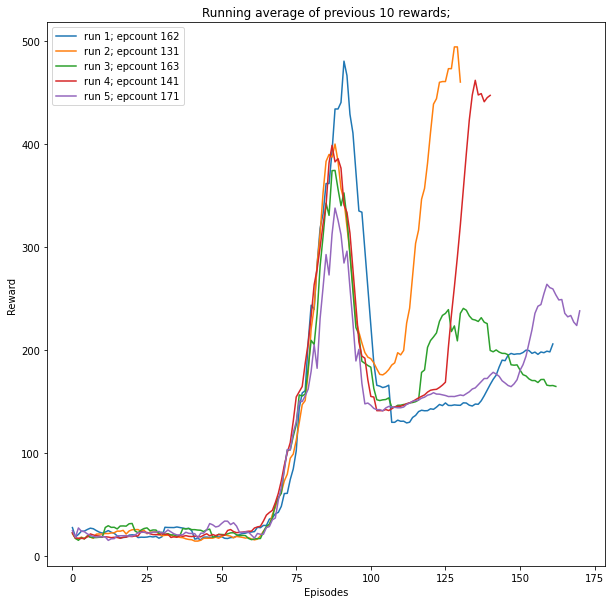

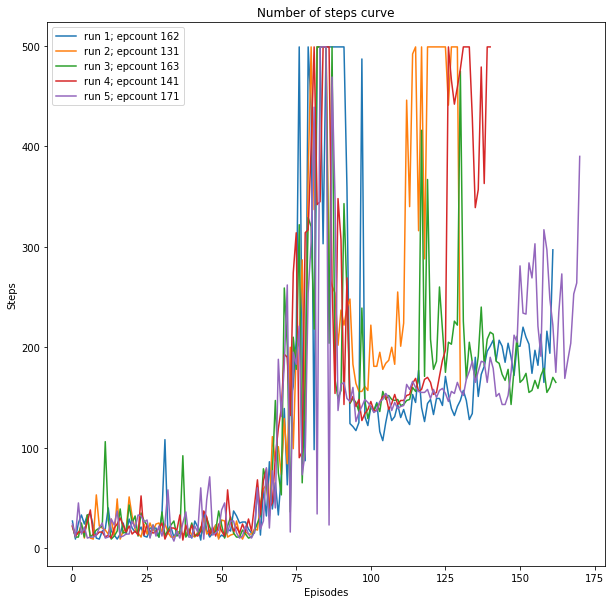

In [ ]:
# Default
BUFFER_SIZE = int(40000)
BATCH_SIZE = 128
GAMMA = 0.99
LR = 5e-4
UPDATE_EVERY = 100
NUM_HLAYERS = 2
HLAYER_SIZES = [64, 128]
TRUNC_LIM = 1e32

fname = str(uuid.uuid4())
print(f'Saved to folder {fname}')
os.mkdir(PATH+'/'+fname)
run_scores, run_steps, ep_count_average, median_agent = dqn_exp_runner('CartPole-v1', num_runs=5, env_score_req=195, 
                                                                     use_eps=True, start=20, end=0.0001, decay_factor=0.95)
print(f'Performance {ep_count_average}')
gen_plots(fname, run_scores, run_steps)
save_gif(fname, 'CartPole-v1', median_agent,max_steps=800)

Saved to folder 5e98d239-f2bd-4394-9149-268053573e36
Episode 100	Average Score: 73.33
Episode 163	Average Score: 198.95	eps 0.004677110792995644
Environment solved in 163 episodes!	Average Score: 198.95
Episode 100	Average Score: 82.28
Episode 165	Average Score: 195.17	eps 0.004221092490678568
Environment solved in 165 episodes!	Average Score: 195.17
Episode 100	Average Score: 80.93
Episode 156	Average Score: 195.59	eps 0.006697495349536301
Environment solved in 156 episodes!	Average Score: 195.59
Episode 100	Average Score: 80.51
Episode 158	Average Score: 197.57	eps 0.006044489552956511
Environment solved in 158 episodes!	Average Score: 197.57
Episode 100	Average Score: 76.65
Episode 200	Average Score: 183.08
Episode 216	Average Score: 196.77	eps 0.0003085522644691827
Environment solved in 216 episodes!	Average Score: 196.77
Performance 171.6


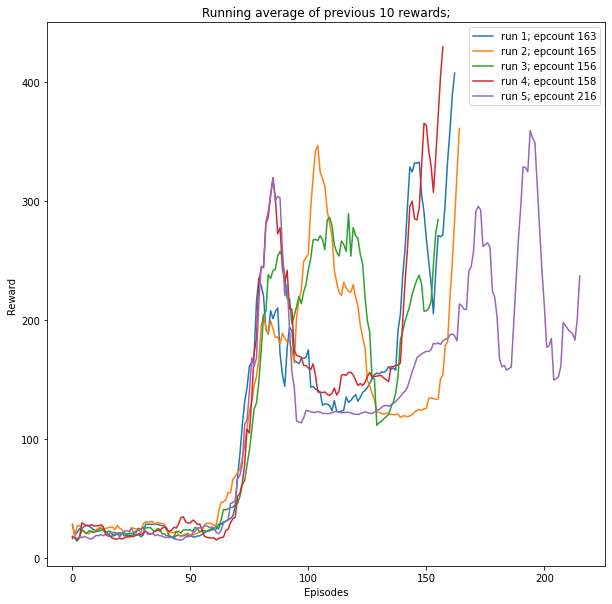

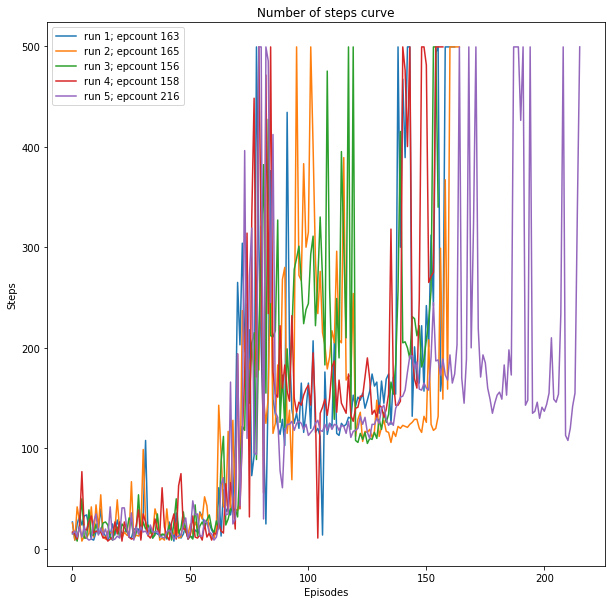

In [ ]:
# From defaults : Learning rate changed to 9e-4
BUFFER_SIZE = int(40000)
BATCH_SIZE = 128
GAMMA = 0.99
LR = 9e-4
UPDATE_EVERY = 100
NUM_HLAYERS = 2
HLAYER_SIZES = [64, 128]
TRUNC_LIM = 1e32

fname = str(uuid.uuid4())
print(f'Saved to folder {fname}')
os.mkdir(PATH+'/'+fname)
run_scores, run_steps, ep_count_average, median_agent = dqn_exp_runner('CartPole-v1', num_runs=5, env_score_req=195, 
                                                                     use_eps=True, start=20, end=0.0001, decay_factor=0.95)
print(f'Performance {ep_count_average}')
gen_plots(fname, run_scores, run_steps)
save_gif(fname, 'CartPole-v1', median_agent,max_steps=800)

Saved to folder 60e8e448-04f8-41c8-9b60-0dacc9a35399
Episode 100	Average Score: 93.49
Episode 160	Average Score: 197.81	eps 0.005455151821543251
Environment solved in 160 episodes!	Average Score: 197.81
Episode 100	Average Score: 84.68
Episode 175	Average Score: 195.69	eps 0.00252732399811099
Environment solved in 175 episodes!	Average Score: 195.69
Episode 100	Average Score: 96.85
Episode 141	Average Score: 196.79	eps 0.014456339584124778
Environment solved in 141 episodes!	Average Score: 196.79
Episode 100	Average Score: 97.32
Episode 171	Average Score: 196.95	eps 0.0031028908594758976
Environment solved in 171 episodes!	Average Score: 196.95
Episode 100	Average Score: 98.78
Episode 135	Average Score: 195.17	eps 0.01966603055821159
Environment solved in 135 episodes!	Average Score: 195.17
Performance 156.4


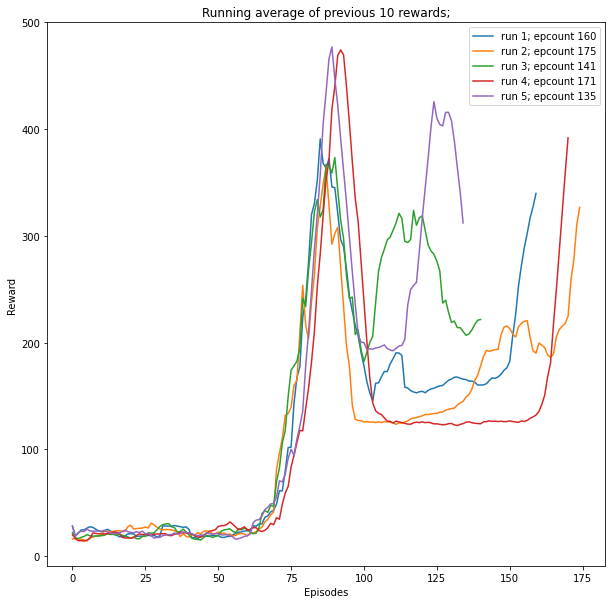

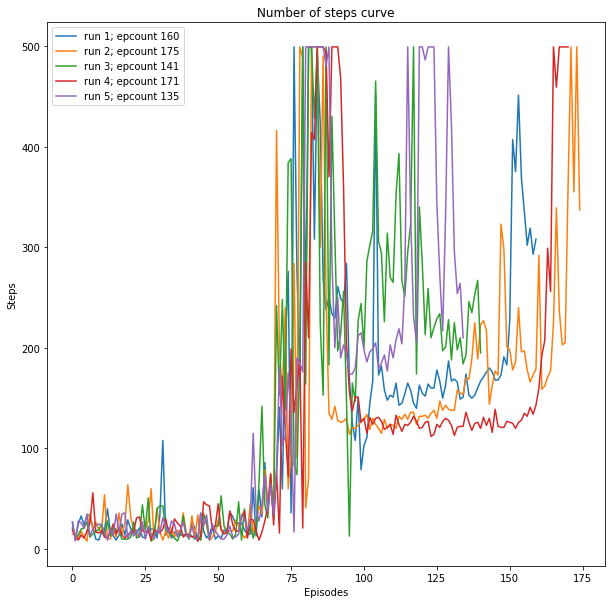

In [ ]:
# Changed from defaults: Buffer size to 80000
BUFFER_SIZE = int(80000)
BATCH_SIZE = 128
GAMMA = 0.99
LR = 5e-4
UPDATE_EVERY = 100
NUM_HLAYERS = 2
HLAYER_SIZES = [64, 128]
TRUNC_LIM = 1e32

fname = str(uuid.uuid4())
print(f'Saved to folder {fname}')
os.mkdir(PATH+'/'+fname)
run_scores, run_steps, ep_count_average, median_agent = dqn_exp_runner('CartPole-v1', num_runs=5, env_score_req=195, 
                                                                     use_eps=True, start=20, end=0.0001, decay_factor=0.95)
print(f'Performance {ep_count_average}')
gen_plots(fname, run_scores, run_steps)
save_gif(fname, 'CartPole-v1', median_agent,max_steps=800)

Saved to folder e1bc46f9-923c-401c-9fc8-2f87e139ef62
Episode 100	Average Score: 93.49
Episode 172	Average Score: 196.10	eps 0.0029477463165021025
Environment solved in 172 episodes!	Average Score: 196.10
Episode 100	Average Score: 78.75
Episode 150	Average Score: 196.48	eps 0.009111099489673142
Environment solved in 150 episodes!	Average Score: 196.48
Episode 100	Average Score: 101.37
Episode 155	Average Score: 198.24	eps 0.007049995104775054
Environment solved in 155 episodes!	Average Score: 198.24
Episode 100	Average Score: 102.36
Episode 139	Average Score: 197.31	eps 0.016018104802354327
Environment solved in 139 episodes!	Average Score: 197.31
Episode 100	Average Score: 89.81
Episode 139	Average Score: 198.99	eps 0.016018104802354327
Environment solved in 139 episodes!	Average Score: 198.99
Performance 151.0


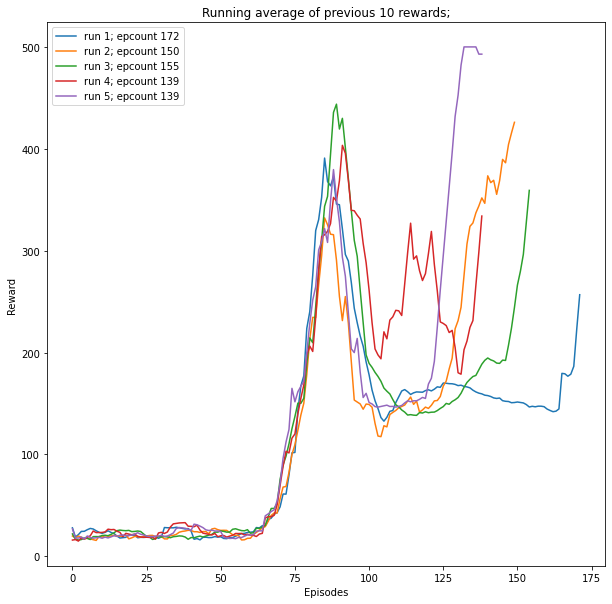

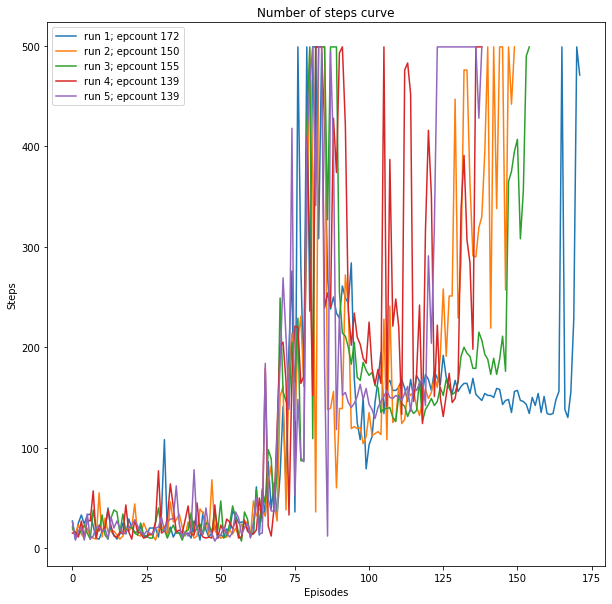

In [ ]:
# Changed from defaults: Buffer size to 10000
BUFFER_SIZE = int(10000)
BATCH_SIZE = 128
GAMMA = 0.99
LR = 5e-4
UPDATE_EVERY = 100
NUM_HLAYERS = 2
HLAYER_SIZES = [64, 128]
TRUNC_LIM = 1e32

fname = str(uuid.uuid4())
print(f'Saved to folder {fname}')
os.mkdir(PATH+'/'+fname)
run_scores, run_steps, ep_count_average, median_agent = dqn_exp_runner('CartPole-v1', num_runs=5, env_score_req=195, 
                                                                     use_eps=True, start=20, end=0.0001, decay_factor=0.95)
print(f'Performance {ep_count_average}')
gen_plots(fname, run_scores, run_steps)
save_gif(fname, 'CartPole-v1', median_agent,max_steps=800)

Saved to folder 65b39ced-29ad-4eef-a02f-968b85903551
Episode 100	Average Score: 95.30
Episode 130	Average Score: 196.05	eps 0.02541550147481062
Environment solved in 130 episodes!	Average Score: 196.05
Episode 100	Average Score: 116.71
Episode 142	Average Score: 198.30	eps 0.013733522604918539
Environment solved in 142 episodes!	Average Score: 198.30
Episode 100	Average Score: 102.28
Episode 154	Average Score: 196.18	eps 0.007421047478710583
Environment solved in 154 episodes!	Average Score: 196.18
Episode 100	Average Score: 98.50
Episode 142	Average Score: 196.01	eps 0.013733522604918539
Environment solved in 142 episodes!	Average Score: 196.01
Episode 100	Average Score: 95.76
Episode 129	Average Score: 199.58	eps 0.026753159447169078
Environment solved in 129 episodes!	Average Score: 199.58
Performance 139.4


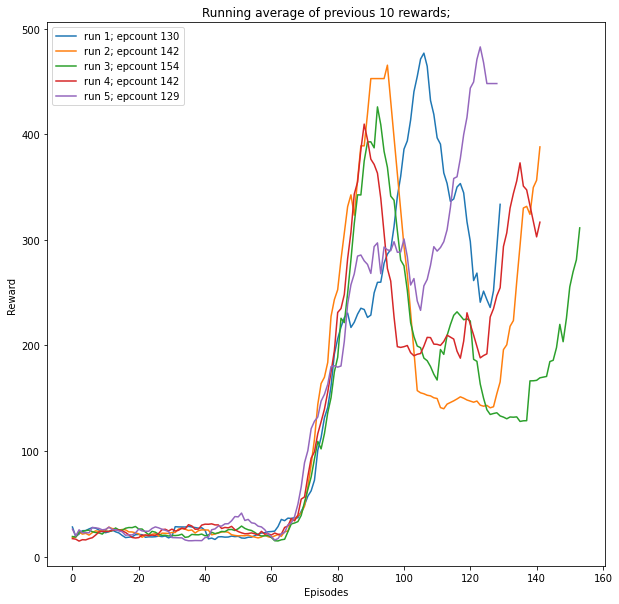

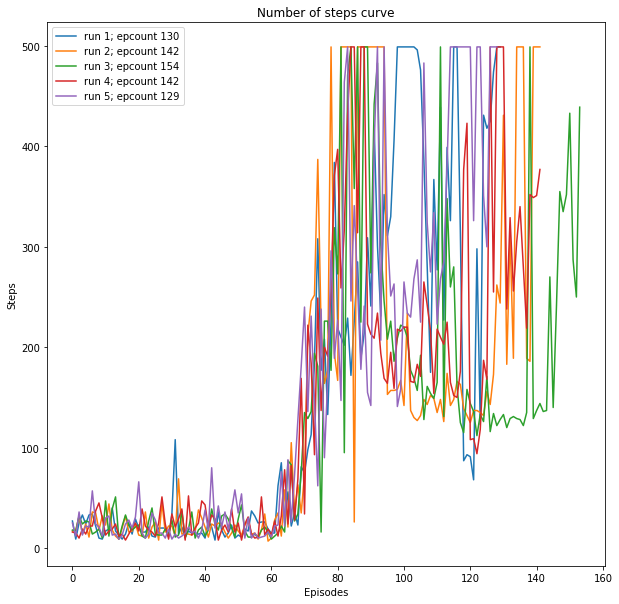

In [ ]:
# Changed from defaults: Buffer size to 10000 and batch size to 64
BUFFER_SIZE = int(10000)
BATCH_SIZE = 64
GAMMA = 0.99
LR = 5e-4
UPDATE_EVERY = 100
NUM_HLAYERS = 2
HLAYER_SIZES = [64, 128]
TRUNC_LIM = 1e32

fname = str(uuid.uuid4())
print(f'Saved to folder {fname}')
os.mkdir(PATH+'/'+fname)
run_scores, run_steps, ep_count_average, median_agent = dqn_exp_runner('CartPole-v1', num_runs=5, env_score_req=195, 
                                                                     use_eps=True, start=20, end=0.0001, decay_factor=0.95)
print(f'Performance {ep_count_average}')
gen_plots(fname, run_scores, run_steps)
save_gif(fname, 'CartPole-v1', median_agent,max_steps=800)

Saved to folder a31ab355-03af-4307-a56a-31abde36ab97
Episode 100	Average Score: 73.36
Episode 152	Average Score: 197.14	eps 0.00822276728943001
Environment solved in 152 episodes!	Average Score: 197.14
Episode 100	Average Score: 99.24
Episode 150	Average Score: 195.35	eps 0.009111099489673142
Environment solved in 150 episodes!	Average Score: 195.35
Episode 100	Average Score: 95.15
Episode 145	Average Score: 198.49	eps 0.01177477894339203
Environment solved in 145 episodes!	Average Score: 198.49
Episode 100	Average Score: 110.61
Episode 135	Average Score: 196.25	eps 0.01966603055821159
Environment solved in 135 episodes!	Average Score: 196.25
Episode 100	Average Score: 74.94
Episode 166	Average Score: 195.88	eps 0.00401003786614464
Environment solved in 166 episodes!	Average Score: 195.88
Performance 149.6


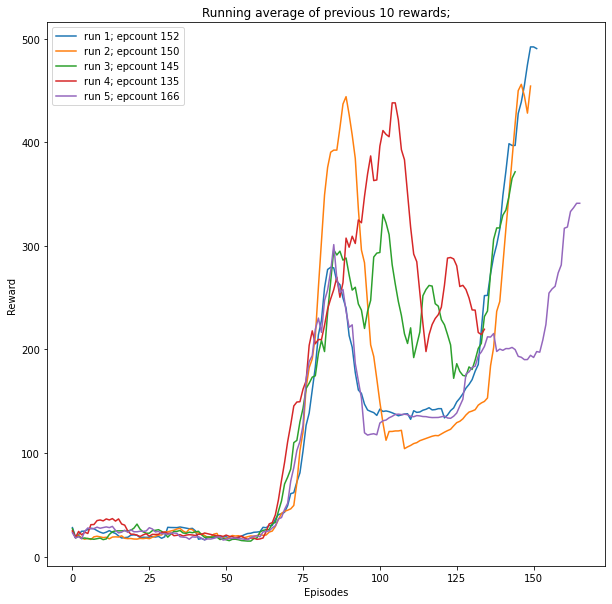

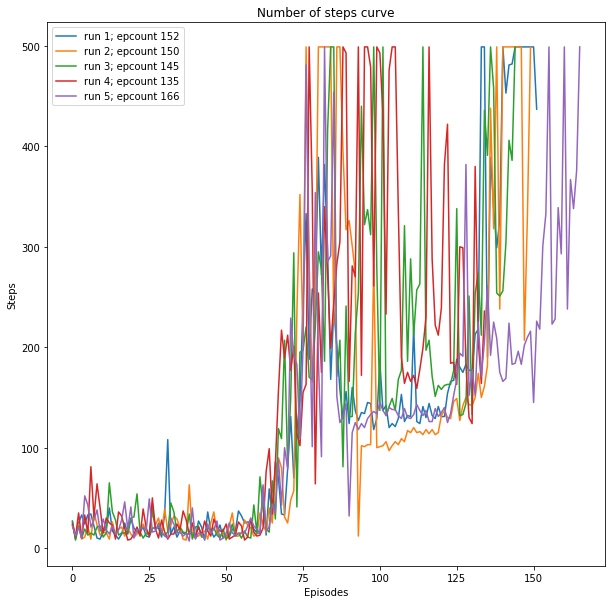

In [ ]:
# Changed from defaults: Buffer size to 10000 and batch size to 256
BUFFER_SIZE = int(10000)
BATCH_SIZE = 256
GAMMA = 0.99
LR = 5e-4
UPDATE_EVERY = 100
NUM_HLAYERS = 2
HLAYER_SIZES = [64, 128]
TRUNC_LIM = 1e32

fname = str(uuid.uuid4())
print(f'Saved to folder {fname}')
os.mkdir(PATH+'/'+fname)
run_scores, run_steps, ep_count_average, median_agent = dqn_exp_runner('CartPole-v1', num_runs=5, env_score_req=195, 
                                                                     use_eps=True, start=20, end=0.0001, decay_factor=0.95)
print(f'Performance {ep_count_average}')
gen_plots(fname, run_scores, run_steps)
save_gif(fname, 'CartPole-v1', median_agent,max_steps=800)

Saved to folder 14c0cf8e-a20e-4af2-8c09-6b99dd0bba1e
Episode 100	Average Score: 46.89
Episode 167	Average Score: 195.57	eps 0.0038095359728374076
Environment solved in 167 episodes!	Average Score: 195.57
Episode 100	Average Score: 100.12
Episode 123	Average Score: 199.08	eps 0.036394306328726665
Environment solved in 123 episodes!	Average Score: 199.08
Episode 100	Average Score: 64.51
Episode 136	Average Score: 195.35	eps 0.01868272903030101
Environment solved in 136 episodes!	Average Score: 195.35
Episode 100	Average Score: 89.28
Episode 142	Average Score: 195.68	eps 0.013733522604918539
Environment solved in 142 episodes!	Average Score: 195.68
Episode 100	Average Score: 86.44
Episode 132	Average Score: 198.27	eps 0.022937490081016584
Environment solved in 132 episodes!	Average Score: 198.27
Performance 140.0


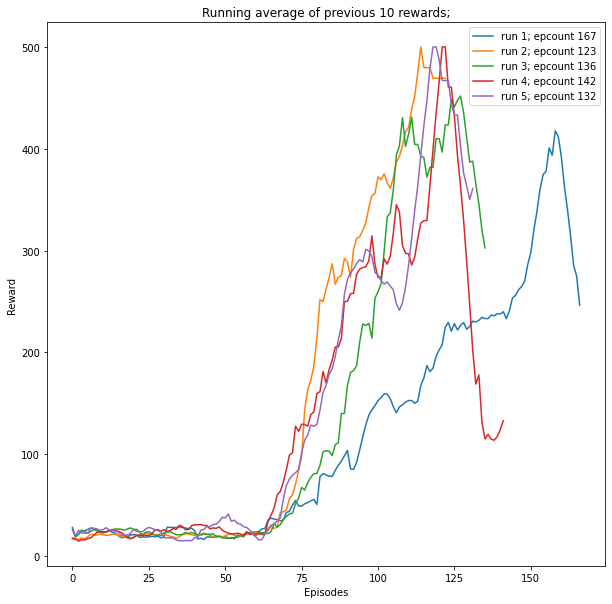

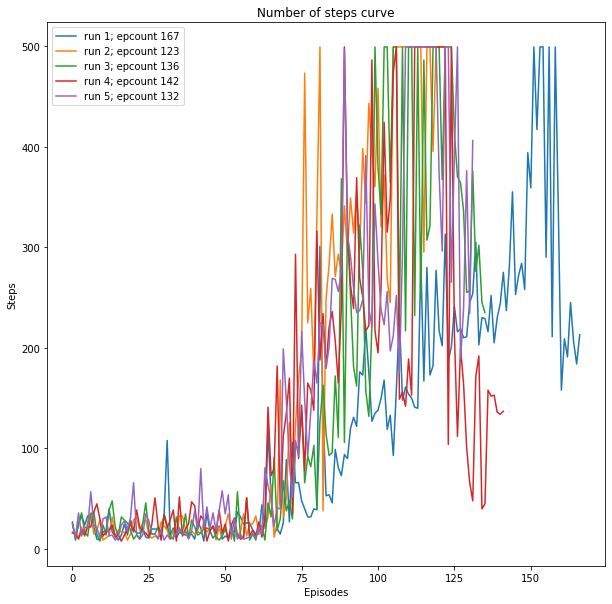

In [ ]:
# Changed from defaults: Buffer size to 10000 and batch size to 64,update every=20
BUFFER_SIZE = int(10000)
BATCH_SIZE = 64
GAMMA = 0.99
LR = 5e-4
UPDATE_EVERY = 20
NUM_HLAYERS = 2
HLAYER_SIZES = [64, 128]
TRUNC_LIM = 1e32

fname = str(uuid.uuid4())
print(f'Saved to folder {fname}')
os.mkdir(PATH+'/'+fname)
run_scores, run_steps, ep_count_average, median_agent = dqn_exp_runner('CartPole-v1', num_runs=5, env_score_req=195, 
                                                                     use_eps=True, start=20, end=0.0001, decay_factor=0.95)
print(f'Performance {ep_count_average}')
gen_plots(fname, run_scores, run_steps)
save_gif(fname, 'CartPole-v1', median_agent,max_steps=800)

Saved to folder ec3da963-0a68-4ebf-875d-8a5d2df290a4
Episode 100	Average Score: 82.47
Episode 129	Average Score: 195.75	eps 0.026753159447169078
Environment solved in 129 episodes!	Average Score: 195.75
Episode 100	Average Score: 112.50
Episode 123	Average Score: 199.79	eps 0.036394306328726665
Environment solved in 123 episodes!	Average Score: 199.79
Episode 100	Average Score: 96.97
Episode 128	Average Score: 196.29	eps 0.028161220470704296
Environment solved in 128 episodes!	Average Score: 196.29
Episode 100	Average Score: 101.78
Episode 145	Average Score: 197.59	eps 0.01177477894339203
Environment solved in 145 episodes!	Average Score: 197.59
Episode 100	Average Score: 94.36
Episode 126	Average Score: 195.38	eps 0.03120356838859202
Environment solved in 126 episodes!	Average Score: 195.38
Performance 130.2


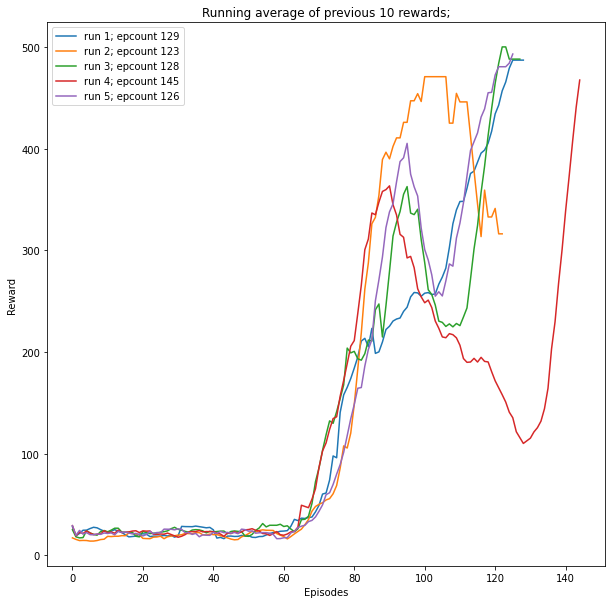

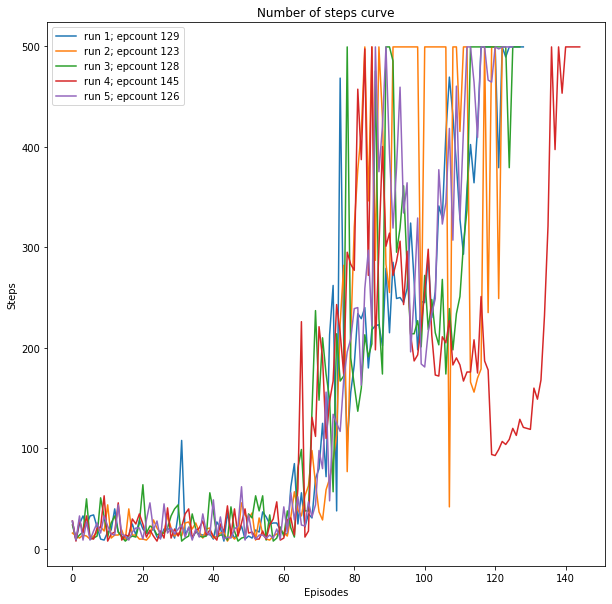

In [ ]:
# Changed from defaults: Buffer size to 10000 and batch size to 64,update every=50
BUFFER_SIZE = int(10000)
BATCH_SIZE = 64
GAMMA = 0.99
LR = 5e-4
UPDATE_EVERY = 50
NUM_HLAYERS = 2
HLAYER_SIZES = [64, 128]
TRUNC_LIM = 1e32

fname = str(uuid.uuid4())
print(f'Saved to folder {fname}')
os.mkdir(PATH+'/'+fname)
run_scores, run_steps, ep_count_average, median_agent = dqn_exp_runner('CartPole-v1', num_runs=5, env_score_req=195, 
                                                                     use_eps=True, start=20, end=0.0001, decay_factor=0.95)
print(f'Performance {ep_count_average}')
gen_plots(fname, run_scores, run_steps)
save_gif(fname, 'CartPole-v1', median_agent,max_steps=800)

Saved to folder 82d7638a-47a9-405a-b605-0374d461d603
Episode 80	Average Score: 195.60	eps 0.004369490010567851
Environment solved in 80 episodes!	Average Score: 195.60
Episode 73	Average Score: 198.66	eps 0.009135518149015497
Environment solved in 73 episodes!	Average Score: 198.66
Episode 100	Average Score: 161.43
Episode 122	Average Score: 195.30	eps 0.0001
Environment solved in 122 episodes!	Average Score: 195.30
Episode 72	Average Score: 195.36	eps 0.01015057572112833
Environment solved in 72 episodes!	Average Score: 195.36
Episode 68	Average Score: 196.07	eps 0.015471080202908593
Environment solved in 68 episodes!	Average Score: 196.07
Performance 83.0


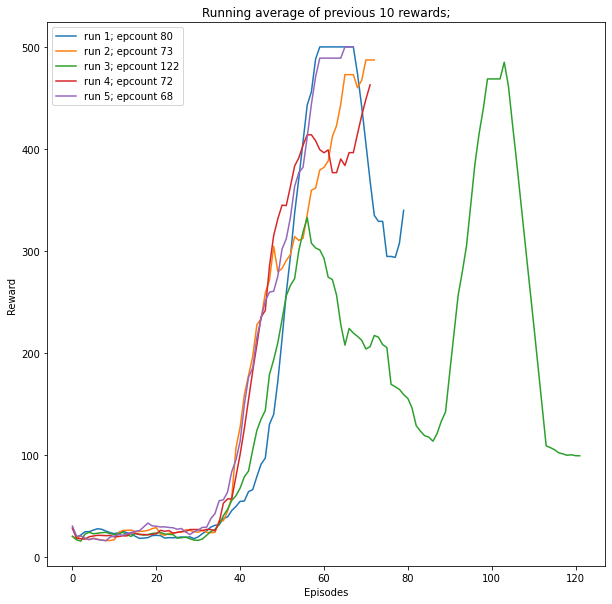

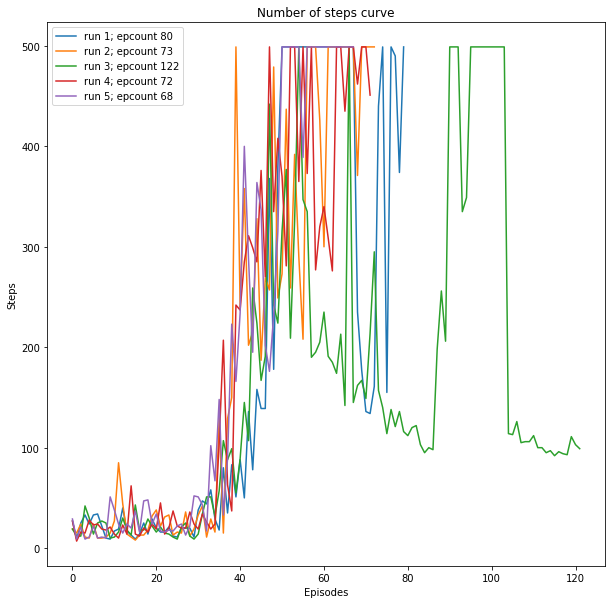

In [ ]:
# Changed from defaults: Buffer size to 10000 and batch size to 64,update every=50,decay factor=0.9
BUFFER_SIZE = int(10000)
BATCH_SIZE = 64
GAMMA = 0.99
LR = 5e-4
UPDATE_EVERY = 50
NUM_HLAYERS = 2
HLAYER_SIZES = [64, 128]
TRUNC_LIM = 1e32

fname = str(uuid.uuid4())
print(f'Saved to folder {fname}')
os.mkdir(PATH+'/'+fname)
run_scores, run_steps, ep_count_average, median_agent = dqn_exp_runner('CartPole-v1', num_runs=5, env_score_req=195, 
                                                                     use_eps=True, start=20, end=0.0001, decay_factor=0.9)
print(f'Performance {ep_count_average}')
gen_plots(fname, run_scores, run_steps)
save_gif(fname, 'CartPole-v1', median_agent,max_steps=800)

Saved to folder 27908954-2dde-4bca-aa52-b3882190d74a
Episode 80	Average Score: 195.60	eps 0.004369490010567851
Environment solved in 80 episodes!	Average Score: 195.60
Episode 73	Average Score: 198.66	eps 0.009135518149015497
Environment solved in 73 episodes!	Average Score: 198.66
Episode 100	Average Score: 161.43
Episode 122	Average Score: 195.30	eps 5.231378549157673e-05
Environment solved in 122 episodes!	Average Score: 195.30
Episode 72	Average Score: 195.36	eps 0.01015057572112833
Environment solved in 72 episodes!	Average Score: 195.36
Episode 68	Average Score: 196.07	eps 0.015471080202908593
Environment solved in 68 episodes!	Average Score: 196.07
Performance 83.0


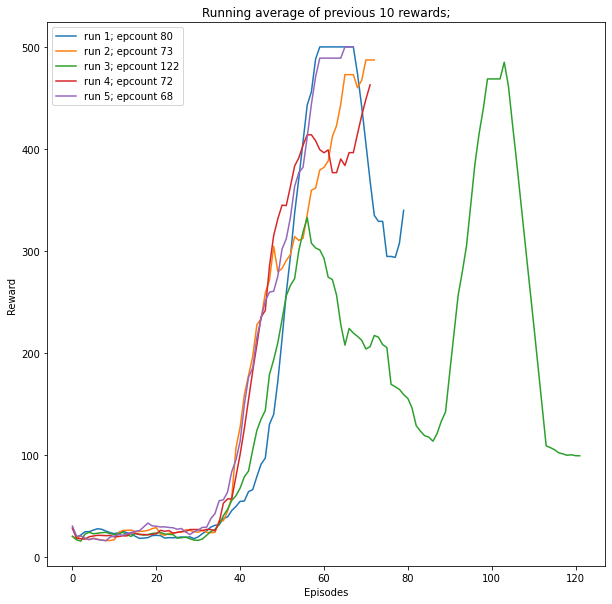

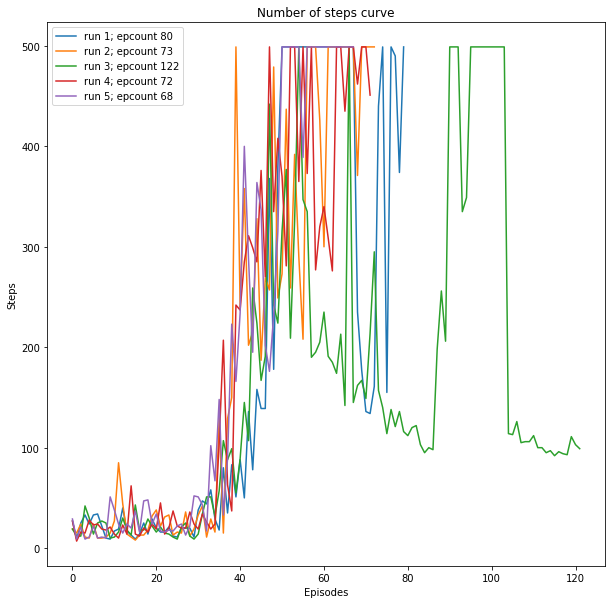

In [ ]:
# Changed from defaults: Buffer size to 10000 and batch size to 64,update every=50,decay factor=0.9,epsilon_end=0.00001
BUFFER_SIZE = int(10000)
BATCH_SIZE = 64
GAMMA = 0.99
LR = 5e-4
UPDATE_EVERY = 50
NUM_HLAYERS = 2
HLAYER_SIZES = [64, 128]
TRUNC_LIM = 1e32

fname = str(uuid.uuid4())
print(f'Saved to folder {fname}')
os.mkdir(PATH+'/'+fname)
run_scores, run_steps, ep_count_average, median_agent = dqn_exp_runner('CartPole-v1', num_runs=5, env_score_req=195, 
                                                                     use_eps=True, start=20, end=0.00001, decay_factor=0.9)
print(f'Performance {ep_count_average}')
gen_plots(fname, run_scores, run_steps)
save_gif(fname, 'CartPole-v1', median_agent,max_steps=800)

Saved to folder 999fdc2b-77ec-4867-9976-5dfac0bfbc3f
Episode 82	Average Score: 195.66	eps 0.05
Environment solved in 82 episodes!	Average Score: 195.66
Episode 92	Average Score: 195.25	eps 0.05
Environment solved in 92 episodes!	Average Score: 195.25
Episode 81	Average Score: 196.16	eps 0.05
Environment solved in 81 episodes!	Average Score: 196.16
Episode 82	Average Score: 195.94	eps 0.05
Environment solved in 82 episodes!	Average Score: 195.94
Episode 92	Average Score: 195.82	eps 0.05
Environment solved in 92 episodes!	Average Score: 195.82
Performance 85.8


<ipython-input-6-4c3fc3a85a06>:66: RuntimeWarning: divide by zero encountered in true_divide
  return self.rsg.choice(np.arange(self.action_size), size=1, p=softmax(a_values/beta))[0]
/usr/local/lib/python3.9/dist-packages/scipy/special/_logsumexp.py:224: RuntimeWarning: invalid value encountered in subtract
  exp_x_shifted = np.exp(x - x_max)


ValueError: ignored

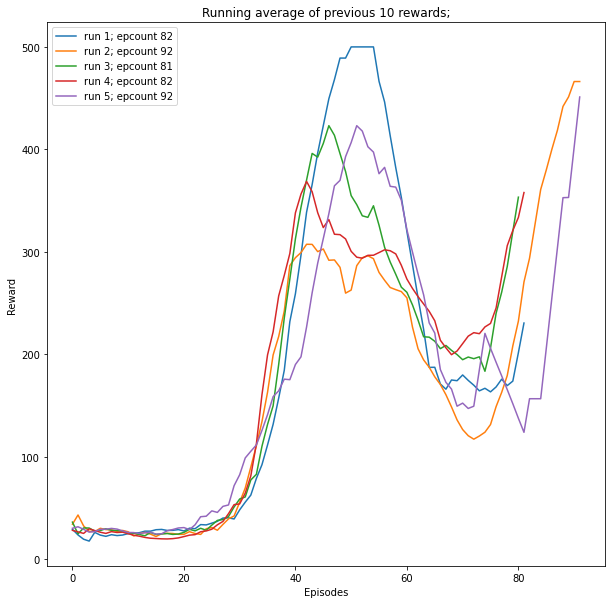

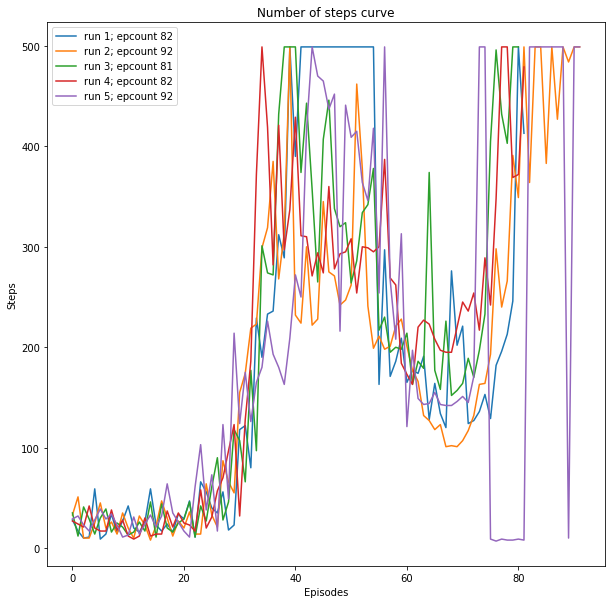

In [ ]:
# Changed from defaults: Buffer size to 10000 and batch size to 64,update every=50,decay factor=0.9,epsilon_end=0.000001,softmax
BUFFER_SIZE = int(10000)
BATCH_SIZE = 64
GAMMA = 0.99
LR = 5e-4
UPDATE_EVERY = 50
NUM_HLAYERS = 2
HLAYER_SIZES = [64, 128]
TRUNC_LIM = 1e32

fname = str(uuid.uuid4())
print(f'Saved to folder {fname}')
os.mkdir(PATH+'/'+fname)
run_scores, run_steps, ep_count_average, median_agent = dqn_exp_runner('CartPole-v1', num_runs=5, env_score_req=195, 
                                                                     use_eps=False, start=40, end=0.00001, decay_factor=0.9)
print(f'Performance {ep_count_average}')
gen_plots(fname, run_scores, run_steps)
save_gif(fname, 'CartPole-v1', median_agent,max_steps=800)

Saved to folder 6fa6014e-2af5-402d-81ec-0f1a27b807f3
Episode 31	Average Score: 201.32	eps 0.05
Environment solved in 31 episodes!	Average Score: 201.32
Episode 32	Average Score: 201.62	eps 0.05
Environment solved in 32 episodes!	Average Score: 201.62
Episode 34	Average Score: 202.38	eps 0.05
Environment solved in 34 episodes!	Average Score: 202.38
Episode 30	Average Score: 197.00	eps 0.05
Environment solved in 30 episodes!	Average Score: 197.00
Episode 19	Average Score: 200.32	eps 0.05
Environment solved in 19 episodes!	Average Score: 200.32
Performance 29.2


<ipython-input-6-4c3fc3a85a06>:66: RuntimeWarning: divide by zero encountered in true_divide
  return self.rsg.choice(np.arange(self.action_size), size=1, p=softmax(a_values/beta))[0]
/usr/local/lib/python3.9/dist-packages/scipy/special/_logsumexp.py:224: RuntimeWarning: invalid value encountered in subtract
  exp_x_shifted = np.exp(x - x_max)


ValueError: ignored

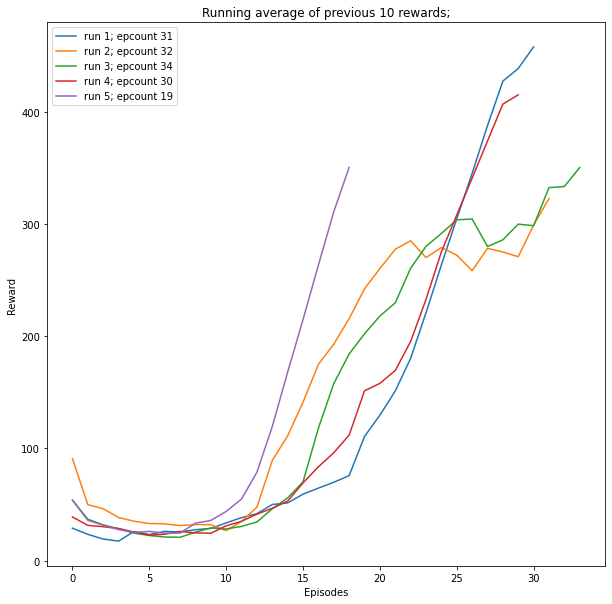

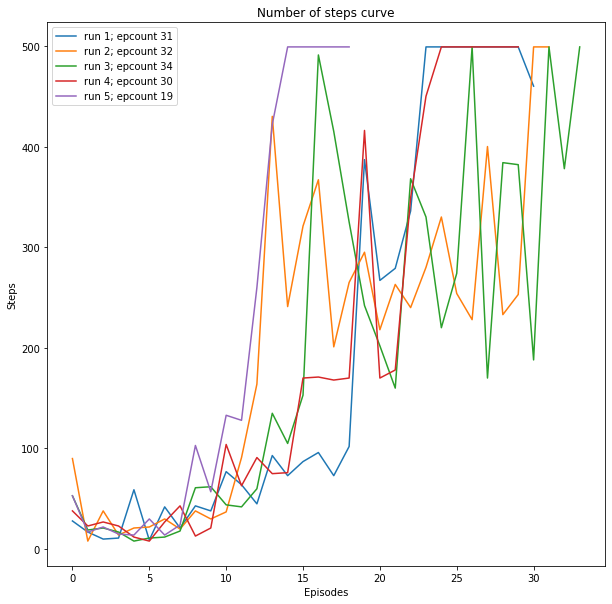

In [ ]:
# Changed from defaults: Buffer size to 10000 and batch size to 64,update every=50,decay factor=0.6,epsilon_end=0.00001,softmax
BUFFER_SIZE = int(10000)
BATCH_SIZE = 64
GAMMA = 0.99
LR = 5e-4
UPDATE_EVERY = 50
NUM_HLAYERS = 2
HLAYER_SIZES = [64, 128]
TRUNC_LIM = 1e32

fname = str(uuid.uuid4())
print(f'Saved to folder {fname}')
os.mkdir(PATH+'/'+fname)
run_scores, run_steps, ep_count_average, median_agent = dqn_exp_runner('CartPole-v1', num_runs=5, env_score_req=195, 
                                                                     use_eps=False, start=40, end=0.00001, decay_factor=0.6)
print(f'Performance {ep_count_average}')
gen_plots(fname, run_scores, run_steps)
save_gif(fname, 'CartPole-v1', median_agent,max_steps=800)